# This task will enable us to forecast on a datetime object

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 

%matplotlib inline
warnings.filterwarnings('ignore')

DATA Description 
 - Advanced Monthly sales for Retail and food services 
 - The Units are in milliond of Dollars
 - The Frequency is Monthly
 
The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation: U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, 01 jun 2023

https://fred.stlouisfed.org/series/RSCCASN


In [5]:
#data 
df = pd.read_csv('../DATA/MRTSSM448USN.csv',index_col='DATE',parse_dates=True)
df.head()

,MRTSSM448USN
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


In [6]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

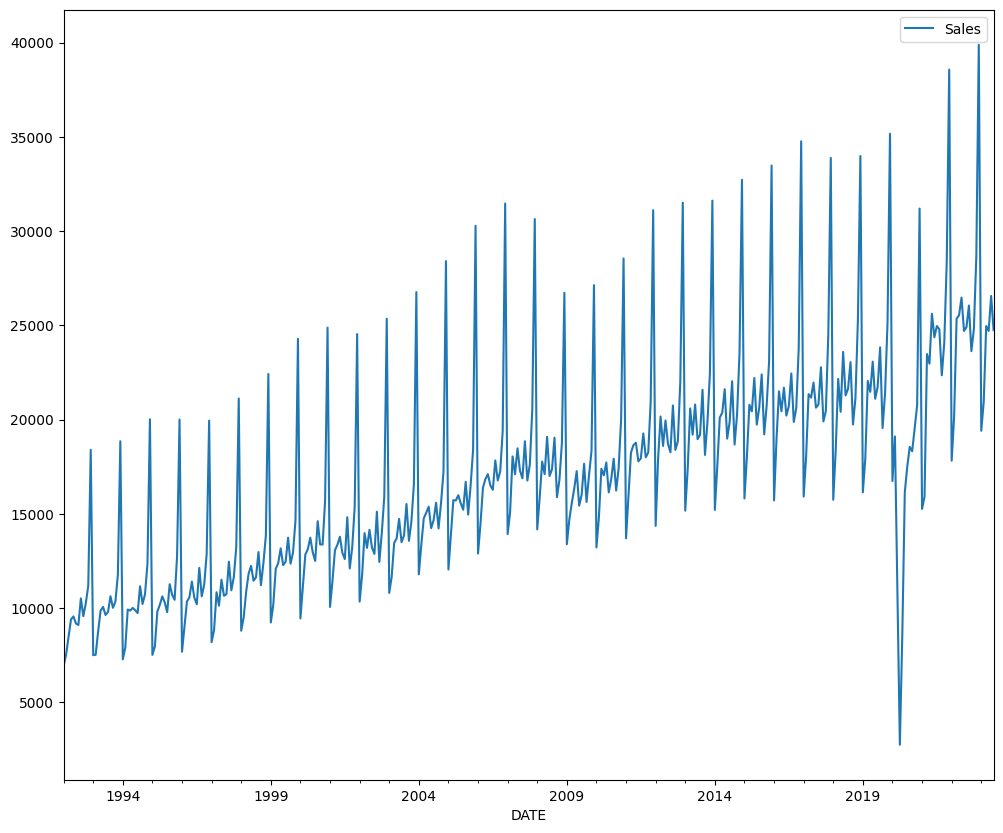

In [8]:
df.plot(figsize=(12,10))

In [9]:
len(df)

378

In [10]:
len(df) - 18

360

In [11]:
test_size = 18
test_index = len(df) - test_size

In [12]:
# Training and test set

In [13]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [14]:
train

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0
...,...
2021-08-01,24789.0
2021-09-01,22347.0
2021-10-01,24062.0


In [15]:
test

,Sales
DATE,
2022-01-01,17817.0
2022-02-01,20152.0
2022-03-01,25347.0
2022-04-01,25539.0
2022-05-01,26470.0
2022-06-01,24701.0
2022-07-01,24904.0
2022-08-01,26049.0
2022-09-01,23629.0


In [17]:
# scalling the data
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
scaler.fit(train)

MinMaxScaler()

In [20]:
scaled_train = scaler.transform(train)

In [21]:
scaled_test = scaler.transform(test)

In [22]:
# Time series Generator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [24]:
# Defining the Batches 
#len(test) the batch should be shorter than 18

length = 12 
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)

In [25]:
X,y = generator[0]

In [27]:
## Model Creation

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [29]:
n_features = 1 

In [30]:
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Adding early stopping
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [45]:
# Validation generator
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)


In [53]:
model.fit_generator(generator,epochs=8,
                   validation_data=validation_generator,
                    callbacks=[early_stop]
                   )

Epoch 1/8
348/348 [==============================] - 2s 7ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 2/8
348/348 [==============================] - 3s 7ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 3/8
348/348 [==============================] - 3s 7ms/step - loss: 0.0023 - val_loss: 5.7680e-04
Epoch 4/8
348/348 [==============================] - 2s 7ms/step - loss: 0.0022 - val_loss: 6.5780e-04
Epoch 5/8
348/348 [==============================] - 2s 6ms/step - loss: 0.0022 - val_loss: 0.0028


In [54]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

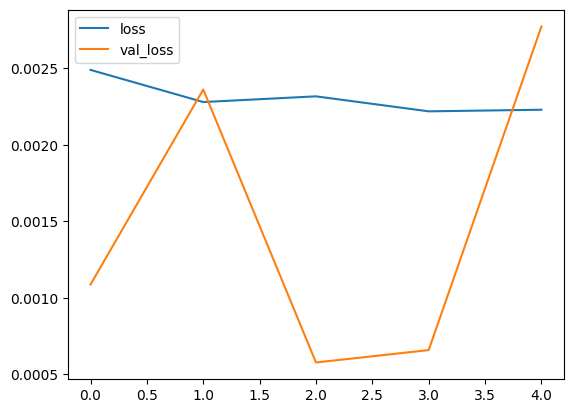

In [55]:
losses.plot()

In [57]:
predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 28ms/step


In [58]:
true_predictions = scaler.inverse_transform(predictions)